In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
import scipy
from scipy.special import sph_harm
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import dipole
import tools

In [3]:
# construct theta and phi for healpix
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
theta, phi = hp.pix2ang(NSIDE, ipix=np.arange(NPIX))

### $Y_{\ell m}$

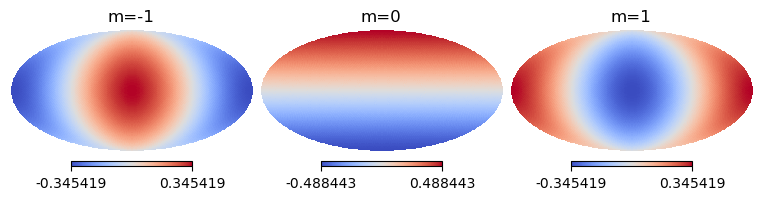

In [4]:
# scipy's function
n = 1
ms = np.linspace(-1,1,3)
# Y_lms
Y_lms = [
    sph_harm(m, n, phi, theta) for m in ms
]
fig = plt.figure(figsize=(2.5 * len(ms),2))
for i, m in enumerate(ms):
    hp.mollview(Y_lms[i].real, title=f'm={m:.0f}', sub=(1,len(ms),i+1), cmap='coolwarm')

#### construct the real components

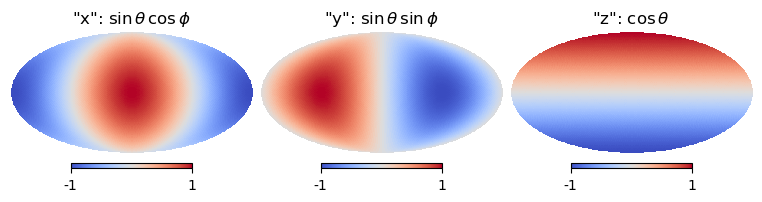

In [5]:
# my dipole function
titles = [
    r'"x": $\sin\theta\,\cos\phi$',
    r'"y": $\sin\theta\,\sin\phi$',
    r'"z": $\cos\theta$'
]

my_dip_comps = np.identity(3)
my_dipole_maps = [ dipole.dipole(theta, phi, *dip_comps) for dip_comps in my_dip_comps ]

fig = plt.figure(figsize=(2.5 * len(ms),2))
for i, m in enumerate(ms):
    hp.mollview(my_dipole_maps[i], title=titles[i], min=-1, max=1, sub=(1,len(ms),i+1), cmap='coolwarm', fig=fig)

/ext3/miniconda3/lib/python3.10/site-packages/healpy/projector.py:201: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


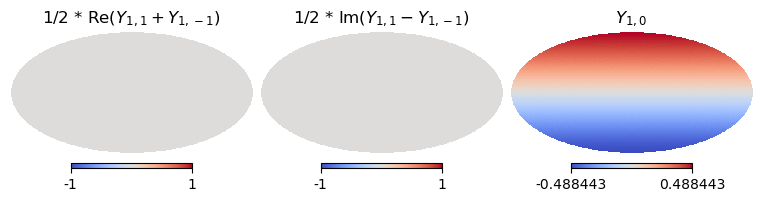

In [6]:
# Hogg's components
components = [
    # half of the real part of the sum
    0.5 * (Y_lms[0]+Y_lms[2]).real,
    # half of the imaginary part of the difference
    0.5 * (Y_lms[0]-Y_lms[2]).imag,
    # m=0 is real
    Y_lms[1]
]

titles = [
    r'1/2 * Re($Y_{1,1}+Y_{1,-1}$)', r'1/2 * Im($Y_{1,1}-Y_{1,-1}$)', r'$Y_{1,0}$'
]

fig = plt.figure(figsize=(2.5 * len(ms),2))
for i, m in enumerate(ms):
    hp.mollview(components[i], title=titles[i], sub=(1,len(ms),i+1), cmap='coolwarm')

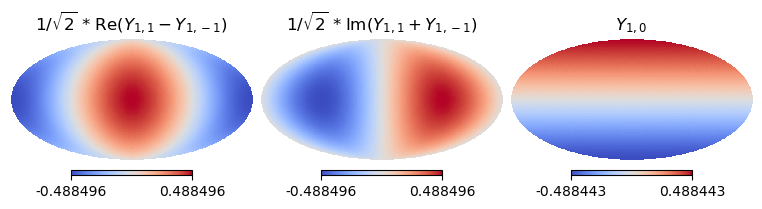

In [9]:
# the "brute force" combination of Y_lms that matches my dipole maps (disregarding amplitudes for now)
components = [
    # half of the real part of the difference
    (1/np.sqrt(2)) * (Y_lms[0]-Y_lms[2]).real,
    # half of the imaginary part of the sum
    (1/np.sqrt(2)) * (Y_lms[0]+Y_lms[2]).imag,
    # m=0 is real
    Y_lms[1]
]

titles = [
    r'1/$\sqrt{2}$ * Re($Y_{1,1}-Y_{1,-1}$)', r'1/$\sqrt{2}$ * Im($Y_{1,1}+Y_{1,-1}$)', r'$Y_{1,0}$'
]

fig = plt.figure(figsize=(2.5 * len(ms),2))
for i, m in enumerate(ms):
    hp.mollview(components[i], title=titles[i], sub=(1,len(ms),i+1), cmap='coolwarm')

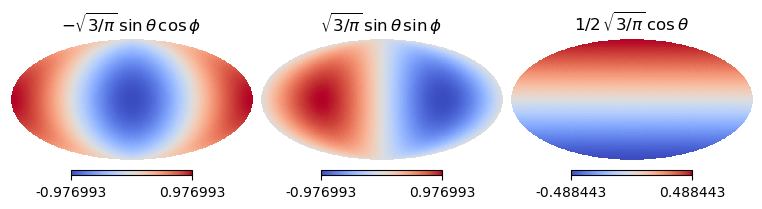

In [11]:
# my "hand-crafted" components from pen and paper
components = [
    # m = 1
    -np.sqrt(3/np.pi) * np.sin(theta) * np.cos(phi),
    # m = -1
    np.sqrt(3/np.pi) * np.sin(theta) * np.sin(phi),
    # m = 0
    0.5 * np.sqrt(3/np.pi) * np.cos(theta)
]

titles = [
    r'$-\sqrt{3/\pi}\,\sin\theta\,\cos\phi$',
    r'$\sqrt{3/\pi}\,\sin\theta\,\sin\phi$',
    r'$1/2\,\sqrt{3/\pi}\,\cos\theta$'
]

fig = plt.figure(figsize=(2.5 * len(ms),2))
for i, m in enumerate(ms):
    hp.mollview(components[i], title=titles[i], sub=(1,len(ms),i+1), cmap='coolwarm')

### quadrupole

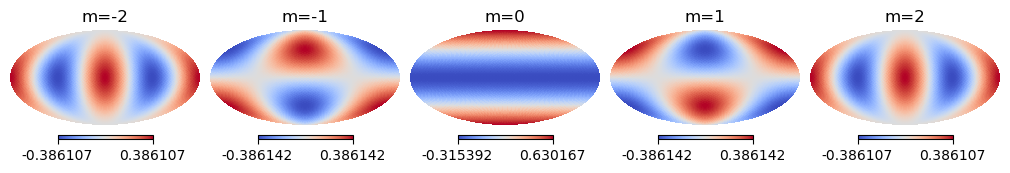

In [12]:
# scipy's function
n = 2
ms = np.linspace(-2,2,5)
fig = plt.figure(figsize=(2 * len(ms),2))
for i, m in enumerate(ms):
    dipole_map_scipy = sph_harm(m, n, phi, theta).real
    hp.mollview(dipole_map_scipy, title=f'm={m:.0f}', sub=(1,len(ms),i+1), cmap='coolwarm', fig=fig)